# OCR notebook
>This notebook uses Tensorflow/Keras to train an OCR model.

#1. Environment preparation

## Import dependencies

Install specific libraries
* **newest Pillow (>8.0.0)**: Few methods (like bbox of text) is only available in newer Pillow versions. 
* **Keras Tuner**: It is needed for Hyperparameter optimization.

In [1]:
!pip install -U keras-tuner
!pip install --upgrade Pillow

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)
Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [2]:
import os
import gc
import copy
import math
import json
import shutil
import urllib
import zipfile
from pathlib import Path
from datetime import datetime
from collections import Counter
import random
import json

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import kerastuner as kt
from kerastuner import HyperParameters

import PIL
from PIL import Image
from PIL import ImageFile
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageFilter
from PIL import ImageEnhance

In [3]:
print(f"Tensorflow {tf.__version__}")
print(f"Numpy {np.__version__}")

Tensorflow 2.4.1
Numpy 1.19.5


In [4]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
# to avoid image file truncated error with huge images
ImageFile.LOAD_TRUNCATED_IMAGES = True

##A: Colab settings

>Run these cells to prepare the environment running on Google Colab (Linux).

In [6]:
sep = "/"
#Edit this to point to project root
home = f"{sep}content{sep}drive{sep}My Drive{sep}Machine Learning{sep}Stolen Vehicle Detector{sep}OCR{sep}"

local_home = f"{sep}content{sep}OCR{sep}"
if not os.path.exists(local_home):
    os.makedirs(local_home)

### Mount Google Drive to this Notebook instance
>As the dataset has been prepared previously and updated to Google Drive, the model building and training process will be done there, not locally.

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir(local_home)
# Show current directory
!pwd

Mounted at /content/drive
/content/OCR


##B: Windows settings

>Run these cells to prepare the environment running on a Windows local machine.

In [ ]:
#Edit this to point to project root
sep = "\\"
home = f"B:{sep}Dev{sep}GitHub{sep}University{sep}MSc Thesis{sep}StolenVehicleDetector{sep}Machine Learning{sep}OCR{sep}"
local_home = f"{home}"

## Define & create directories

>Paths defined to work both remotely and locally.

### A: Create new realm

In [8]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
realm = f"realm_{current_time}"
print(f"Realm create: {realm}")

Realm create: realm_20210502-131017


### B: Load realm

In [ ]:
realm = f"realm_20210418-143210"
print(f"Realm loaded: {realm}")

Realm loaded: realm_20210418-143210


### Create & init directories

In [9]:
source_data_dir = f"{home}data{sep}"
local_data_dir = f"{local_home}data{sep}"

projects_dir = f"{home}projects{sep}"
realm_dir = f"{projects_dir}{realm}{sep}"

training_dir = f"{realm_dir}training{sep}"
checkpoint_dir = f"{training_dir}checkpoint{sep}"
log_dir = f"{training_dir}logs{sep}"

hyperopt_dir = f"{realm_dir}hyperopt{sep}"
hyperopt_logs_dir = f"{hyperopt_dir}logs{sep}"

model_dir = f"{home}model{sep}"
model_tmp_dir = f"{model_dir}tmp{sep}"
keras_dir = f"{model_dir}keras{sep}"
tflite_dir = f"{model_dir}tflite{sep}"

In [10]:
#Setup project directories
if not os.path.exists(home):
    os.makedirs(home)
if not os.path.exists(local_home):
    os.makedirs(local_home)

if not os.path.exists(source_data_dir):
    os.makedirs(source_data_dir)
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

if not os.path.exists(projects_dir):
    os.makedirs(projects_dir)
if not os.path.exists(realm_dir):
    os.makedirs(realm_dir)

if not os.path.exists(training_dir):
    os.makedirs(training_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(hyperopt_dir):
    os.makedirs(hyperopt_dir)
if not os.path.exists(hyperopt_logs_dir):
    os.makedirs(hyperopt_logs_dir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(model_tmp_dir):
    os.makedirs(model_tmp_dir)
if not os.path.exists(keras_dir):
    os.makedirs(keras_dir)
if not os.path.exists(tflite_dir):
    os.makedirs(tflite_dir)

#2. Dataset preparation

##A: Captcha dataset

In [11]:
class AbstractDatasetInit:
    '''Abstract dataset init class
    '''
    dataset_name = ""
    source_url: str = ""

    def __init__(self, data_dir: str) -> None:
        self.data_dir = data_dir
        self.dataset_dir = self.data_dir + self.dataset_name
        self.image_IDs = []
        self.labels = []
        self.characters: set = set()
        self.label_max_length: int = 0

    def __download_dataset(self):
        pass

    def __extract_dataset(self):
        pass

    def prepare(self):
        '''Prepare the whole dataset before working with it
        '''
        pass

    def show_info(self):
        '''Show dataset properties
        '''
        print("Number of images: ", len(self.image_IDs))
        print("Number of labels: ", len(self.labels))
        print("Longest label: ", self.label_max_length)
        print("Number of unique characters: ", len(self.characters))
        print("Characters present: ", self.characters)


class CaptchaDatasetInit(AbstractDatasetInit):
    '''The captcha dataset init class
    '''

    dataset_name = "captcha_images_v2"
    source_url: str = "https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip"

    def __init__(self, data_dir: str) -> None:
        super().__init__(data_dir)
        self.download_file_name = self.dataset_dir + ".zip"

    def __download_dataset(self):
        download_file_path = Path(self.download_file_name)
        if not download_file_path.exists():
            #Not yet downloaded
            urllib.request.urlretrieve(self.source_url, download_file_path)

    def __extract_dataset(self):
        download_file_path = Path(self.download_file_name)
        if download_file_path.exists():
            #if the target data directory is empty, extract the zip file
            with zipfile.ZipFile(self.download_file_name, 'r') as zip_ref:
                zip_ref.extractall(path = self.data_dir)

    def load(self):
        '''Loads the whole dataset before working with it
        '''
        # Download & extract dataset if it has not been yet
        self.__download_dataset()
        self.__extract_dataset()

        dataset_path = Path(self.dataset_dir)
        # Get list of the images
        self.image_IDs = sorted(list(map(str, list(dataset_path.glob("*.png")))))
        # Labels of images: image names minus ".png"
        self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.image_IDs]
        # Set of distinct characters in the labels
        characters = set(char for label in self.labels for char in label)
        self.characters = sorted(characters)
        # Compute the longest label in the dataset
        self.label_max_length = max([len(label) for label in self.labels])

    def split_data(self, train_ratio, shuffle=True):
        # Get the total size of the dataset
        size = len(self.image_IDs)
        # Make an indices array and shuffle it, if required
        indices = np.arange(size)
        if shuffle:
            np.random.shuffle(indices)
        # Get the size of the training samples
        train_samples = int(size * train_ratio)

        images = np.array(self.image_IDs)
        labels = np.array(self.labels)

        # Split data into training and validation sets
        x_train, y_train = images[indices[:train_samples]], images[indices[train_samples:]]
        x_valid, y_valid = labels[indices[:train_samples]], labels[indices[train_samples:]]

        return x_train, x_valid, y_train, y_valid

In [12]:
class CaptchaDatasetWrapper():

    def __init__(self, characters, image_IDs, labels, image_dim=(200,200), n_channels=3, batch_size=16, shuffle=True, max_len=20, oov_token='[?]'):

        self.image_IDs = image_IDs
        # Uniformly transform labels to [0:max_len] sized
        self.labels = [label.ljust(max_len)[0:max_len] for label in labels]
        self.image_dim = image_dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.max_len = max_len
        self.oov_token = oov_token

        self.batch_size = batch_size
        self.num_items = len(self.image_IDs)
        self.num_batches = int(np.floor(self.num_items / self.batch_size))

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=list(characters), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=False
        )

        # Mapping integers back to characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=True
        )

        self.dataset = tf.data.Dataset.from_tensor_slices((self.image_IDs, self.labels))
        self.dataset = self.dataset.shuffle(self.num_items, reshuffle_each_iteration=self.shuffle)
        self.dataset = (
            self.dataset.map(
            self.get_item, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        )

    def data_to_dict(self, image, label):
        # Return a dict
        return {"image": image, "label": label}

    def encode_data(self, img_path, char_label):
        # Read the image
        img = tf.io.read_file(img_path)
        # Decode and convert to have the required amount of channels
        img = tf.io.decode_image(img, channels=self.n_channels)
        # Convert to float32 in [0, 1) range
        img = tf.image.convert_image_dtype(img, tf.float32)
        # Resize to the desired size
        img = tf.image.resize_with_pad(img, self.image_dim[0], self.image_dim[1])

        num_label = self.encode_label(char_label)
        # Return the encoded results
        return img, num_label
        
    def get_item(self, img_path, char_label):
        image, label = self.encode_data(img_path, char_label)
        return self.data_to_dict(image, label)

    def decode_image(self, encoded_image):
        # Only one image
        decoded_image = (encoded_image * 255).numpy().astype("uint8")
        return decoded_image

    def encode_label(self, char_label):
        # keep the characters in the range of [0:self.max_len]
        char_label = tf.strings.substr(char_label, 0, self.max_len, unit='BYTE', name=None)
        # Splits each string in input into a sequence of Unicode code point
        char_label = tf.strings.unicode_split(char_label, input_encoding="UTF-8")
        # Map the characters in a block to numbers
        num_label = self.char_to_num(char_label)
        return num_label

    def decode_label(self, encoded_label, replace_oov):
        # Only one text block
        decoded_label = self.num_to_char(encoded_label)
        decoded_label = tf.strings.reduce_join(decoded_label).numpy().decode("utf-8")
        if replace_oov:
            decoded_label = decoded_label.replace(self.oov_token, '')
        return decoded_label

##B: License plate generator init

### Initializer

In [13]:
class PlateGeneratorInit:
    '''The plate generator init class
    '''

    dataset_name = "plate_generator"
    source_url: str = ""

    def __init__(self, data_dir: str, sep: str) -> None:
        self.dataset_dir = data_dir + self.dataset_name
        self.sep = sep
        self.characters: set = set()
        self.fonts: set = set()
        self.overlays: set = set()

    def __download_sources(self):
        pass

    def load(self):
        '''Loads the dataset generator sources before working with it
        '''
        # Download dataset generator sources if it has not been yet
        self.__download_sources()

        characters_path = Path(f"{self.dataset_dir}{sep}characters.txt")
        # Set of characters
        characters = set(line.strip() for line in open(characters_path))
        self.characters = sorted(characters)

        fonts_path = Path(f"{self.dataset_dir}{sep}fonts{sep}")
        # Set of fonts
        self.fonts = list(map(str, list(fonts_path.glob("*.ttf"))))

        overlays_path = Path(f"{self.dataset_dir}{sep}overlays{sep}")
        # Set of overlays
        self.overlays = list(map(str, list(overlays_path.glob("*.png"))))

    def prepare(self):
        '''Prepare the whole dataset before working with it
        '''
        pass

    def show_info(self):
        '''Show dataset generator properties
        '''
        print("Number of fonts: ", len(self.fonts))
        print("Number of overlay images: ", len(self.overlays))
        print("Number of unique characters: ", len(self.characters))
        print("Characters present: ", self.characters)

### MISC functions

In [14]:
def generate_text(min_len, max_len, characters, replace_chars):
    # random length between the specified range
    text_length = np.random.randint(max_len, size=1)
    text_length += min_len
    # random char sequence
    char_seq = np.random.choice(characters, size=text_length)
    # char sequence to string
    text = ""
    for char in char_seq:
        text += char.upper()
    label_text = text
    # list of tuples of (replace char, target)
    for item in replace_chars:
        source_char = item[0]
        target_char = item[1]
        label_text = label_text.replace(source_char, target_char)
    return text, label_text

In [15]:
def generate_overlay(overlays, image_dim):

    overlay_img = random.choice(overlays)

    img_h = image_dim[0]
    img_w = image_dim[1]

    # random image resize
    resize_ratio = random.uniform(0.5, 2)
    new_h = int(img_h*resize_ratio)
    new_w = int(img_w*resize_ratio)
    overlay_img = overlay_img.resize((new_w, new_h))

    # random image rotation
    random_rotation = random.uniform(0, 360)
    overlay_img = overlay_img.rotate(random_rotation, expand=False)

    return overlay_img

In [16]:
def generate_image(text, image_dim, n_channels, font, overlay,
    min_background_text_color_diff=50, resize_text=(0.85, 1.01), text_aspect_ratio=(0.75, 1.5), random_offset_needed=True, rotation_deg=(-7, 7),
    random_brightness=(0.7, 1.2), random_contrast=(0.5, 2), random_sharpness=(0.1, 2), random_blur=(0, 1.5), random_resolution=(0.3, 1)):
    ''' With these parameters, the worst scenario is that 1 character is 10 pixel wide. 
        In 100 pixels there are maximum 10 characters -> 20 time steps needed per 100 pixels to detect 10 chars + the empty chars between them.
    '''

    img_type = ""
    background_color = (0)
    text_color = (0)
    # generate random colors
    background_color = np.random.randint(255, size=n_channels)
    color_diff_safe_zone = 2*min_background_text_color_diff
    text_color_offset = np.random.randint(255-color_diff_safe_zone, size=1)[0].item() + min_background_text_color_diff
    text_color = (background_color + text_color_offset) % 255
    # if grayscale image is needed, set grayscale type & colors
    if(n_channels == 1):
        img_type = "L"
        background_color = background_color.item()
        text_color = text_color.item()
    # if RGB image is needed, set RGB type & colors
    elif(n_channels == 3):
        img_type = "RGB"
        background_color = tuple(background_color)
        text_color = tuple(text_color)

    img_h = image_dim[0]
    img_w = image_dim[1]

    bb_dim = font.getbbox(text=text, anchor="la")
    bb_h = bb_dim[3]
    bb_w = bb_dim[2]

    # create background image
    background = Image.new(img_type, (img_w, img_h), background_color)
    # create text image
    text_img = Image.new(img_type, (bb_w, bb_h), background_color)
    draw = ImageDraw.Draw(text_img)
    draw.text((0, 0), text, text_color, anchor="la", font=font)
    draw = ImageDraw.Draw(text_img)

    resize_ratio = 1
    # if text is bigger than background in any dimension, calculate resize_ratio to fit text onto the background
    if((bb_w > img_w) or (bb_h > img_h)):
        req_ratio_w = float(img_w)/float(bb_w)
        req_ratio_h = float(img_h)/float(bb_h)
        resize_ratio = min(req_ratio_w, req_ratio_h)
    # multiply resize_ratio with a value in resize_text range
    resize_ratio *= random.uniform(resize_text[0], resize_text[1])
    # resize text
    new_h = int(bb_h*resize_ratio)
    new_w = int(bb_w*resize_ratio)
    text_img = text_img.resize((new_w, new_h))

    # random text aspect ratio change with a value in text_aspect_ratio range
    aspect_ratio_change_width = random.uniform(text_aspect_ratio[0], text_aspect_ratio[1])
    new_w = min(int(aspect_ratio_change_width*new_w), img_w)
    text_img = text_img.resize((new_w, new_h))

    offset = (0, 0)
    # random offset between the specified range to fit background
    if(random_offset_needed):
        h_offset_max = max(1, img_h-new_h)
        w_offset_max = max(1, img_w-new_w)
        rand_h_offset = np.random.randint(h_offset_max, size=1)[0]
        rand_w_offset = np.random.randint(w_offset_max, size=1)[0]
        offset = (rand_w_offset, rand_h_offset)
    background.paste(text_img, offset)

    # random image rotation
    random_rotation = random.uniform(rotation_deg[0], rotation_deg[1])
    background = background.rotate(random_rotation, expand=True, fillcolor=background_color)
    background = background.resize((img_w, img_h))

    # paste overlay image
    overlay_offset = (0, 0)
    # random overlay offset between the specified range to fit background
    h_overlay_offset_max = max(1, img_h-new_h)
    w_overlay_offset_max = max(1, img_w-new_w)
    rand_h_overlay_offset = np.random.randint(h_overlay_offset_max, size=1)[0]
    rand_w_overlay_offset = np.random.randint(w_overlay_offset_max, size=1)[0]
    overlay_offset = (rand_w_overlay_offset, rand_h_overlay_offset)
    background.paste(overlay, overlay_offset, overlay)

    # random image enhancements
    # brightness
    brightness = random.uniform(random_brightness[0], random_brightness[1])
    background = ImageEnhance.Brightness(background).enhance(brightness)
    # contrast
    contrast = random.uniform(random_contrast[0], random_contrast[1])
    background = ImageEnhance.Contrast(background).enhance(contrast)
    # sharpness
    sharpness = random.uniform(random_sharpness[0], random_sharpness[1])
    background = ImageEnhance.Sharpness(background).enhance(sharpness)
    
    # random gaussian blur
    blur = random.uniform(random_blur[0], random_blur[1])
    background = background.filter(ImageFilter.GaussianBlur(blur))

    # random resolution: downscale image
    resolution = random.uniform(random_resolution[0], random_resolution[1])
    resolution_h = int(img_h * resolution)
    resolution_w = int(img_w * resolution)
    background = background.resize((resolution_w, resolution_h))
    # upscale the image to output required dimensions
    background = background.resize((img_w, img_h))

    return background

### Generator wrapper

In [17]:
class PlateGeneratorWrapper():

    def __init__(self, characters, min_len, max_len, font_str_list, font_size, overlay_str_list, image_dim=(50,500), n_channels=3, 
                 batch_size=16, epoch_size=100, oov_token='[?]', replace_chars=[]):
        self.cntr = 0
        self.characters = [char.upper() for char in characters]
        # add space for regularization
        self.characters.append(' ')

        self.vocab_characters = copy.deepcopy(self.characters)
        for item in replace_chars:
            if (item[0] in self.vocab_characters):
                self.vocab_characters.remove(item[0])

        self.min_len = min_len
        self.max_len = max_len

        self.fonts = list(ImageFont.truetype(font_str, font_size) for font_str in font_str_list)
        self.overlays = list(Image.open(overlay_str).convert("RGBA") for overlay_str in overlay_str_list)

        self.image_dim = image_dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        # out of vocabulary token
        self.oov_token = oov_token
        # list of tuples of (replace char, target)
        self.replace_chars = replace_chars

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=list(self.vocab_characters), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=False
        )

        # Mapping integers back to characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=True
        )

        placeholder_tensor = tf.range(self.epoch_size)
        self.dataset = tf.data.Dataset.from_tensor_slices((placeholder_tensor))
        self.dataset = (
            self.dataset
                .map(lambda index : tf.py_function(func=self.get_item, inp=[index], Tout=[tf.float32, tf.int64]), 
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(self.data_to_dict)
                .batch(self.batch_size)
                .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        )

    def encode_data(self, img_path, char_label):
        return self.generate_item()

    def generate_item(self):
        # MISC functions
        label_text = ""
        # while generated label is empty, try again
        while (len(label_text) < 1):
            text, label_text = generate_text(self.min_len, self.max_len, self.characters, self.replace_chars)
        font = random.choice(self.fonts)
        overlay = generate_overlay(self.overlays, self.image_dim)
        image = generate_image(text, self.image_dim, self.n_channels, font, overlay)

        # image to tensor
        image = tf.keras.preprocessing.image.img_to_array(image)
        # Convert to float32 in [0, 1) range
        image = tf.image.convert_image_dtype(image, tf.float32)

        num_label = self.encode_label(label_text)
        # Return the encoded results
        return image, num_label
        
    def get_item(self, index):
        image, label = self.generate_item()
        return image, label

    def data_to_dict(self, image, label):
        # Return a dict
        return {"image": image, "label": label}

    def decode_image(self, encoded_image):
        # Only one image
        decoded_image = np.array(encoded_image, dtype=float)
        decoded_image *= (1/255.0)
        return decoded_image

    def encode_label(self, char_label):
        # Remove spaces from the char_label
        char_label = char_label.replace(" ", "")
        # uppercase string
        char_label = char_label.upper()
        # Pad output char label to have the maximum allowed length
        char_label = char_label.ljust(self.max_len)[0:self.max_len]
        # Splits each string in input into a sequence of Unicode code point
        char_label = tf.strings.unicode_split(char_label, input_encoding="UTF-8")
        # Map the characters in a block to numbers
        num_label = self.char_to_num(char_label)
        return num_label

    def decode_label(self, encoded_label, replace_oov):
        # Only one text block
        decoded_label = self.num_to_char(encoded_label)
        decoded_label = tf.strings.reduce_join(decoded_label).numpy().decode("utf-8")
        if replace_oov:
            decoded_label = decoded_label.replace(self.oov_token, '')
        return decoded_label

#3. Training configuration

## Input parameters

In [18]:
#Required input image dimensions (N x K images)
img_h = 50
img_w = 500
#3 means RGB, 1 means grayscale
n_channels = 3

# Batch size for training and validation
batch_size = 128

train_epoch_size = 100000
val_epoch_size = 10000

In [19]:
# list of tuples of (replace char, target)
replace_chars = [('O','0'), (' ','')]
print(f"Replace chars: {replace_chars}")

Replace chars: [('O', '0'), (' ', '')]


##A: Captcha dataset instantiation

In [20]:
data_loader = CaptchaDatasetInit(local_data_dir)
data_loader.load()
data_loader.show_info()

Number of images:  1040
Number of labels:  1040
Longest label:  5
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [21]:
dataset_characters = data_loader.characters
max_len = 20

#Training set ratio
train_ratio = 0.9
shuffle = True

dataset_characters = data_loader.characters

In [22]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = data_loader.split_data(train_ratio, shuffle)

In [23]:
train = CaptchaDatasetWrapper(dataset_characters, x_train, x_valid, image_dim=(img_h, img_w), n_channels=n_channels, 
    batch_size=batch_size, shuffle=True, max_len=max_len)

validation = CaptchaDatasetWrapper(dataset_characters, y_train, y_valid, image_dim=(img_h, img_w), n_channels=n_channels, 
    batch_size=batch_size, shuffle=False, max_len=max_len)

##B: License plate generator instantiation

In [24]:
data_loader = PlateGeneratorInit(source_data_dir, sep)
data_loader.load()
data_loader.show_info()

Number of fonts:  17
Number of overlay images:  17
Number of unique characters:  37
Characters present:  ['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [25]:
dataset_characters = data_loader.characters

min_len = 1
max_len = 20

font_str_list = data_loader.fonts
font_size = 50

overlay_str_list = data_loader.overlays

In [26]:
validation_overlay_str_list = ['/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/nothing.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/particles1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/dirt1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/dust2.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/fog1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/waterdrops1.png',
                               '/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/data/plate_generator/overlays/waterdrops2.png'
]

In [27]:
train = PlateGeneratorWrapper(dataset_characters, min_len=min_len, max_len=max_len, 
                              font_str_list=font_str_list, font_size=font_size, 
                              overlay_str_list=overlay_str_list, 
                              image_dim=(img_h, img_w), n_channels=n_channels, 
                              batch_size=batch_size, epoch_size=train_epoch_size, replace_chars=replace_chars)

validation = PlateGeneratorWrapper(dataset_characters, min_len=min_len, max_len=max_len, 
                                   font_str_list=font_str_list, font_size=font_size, 
                                   overlay_str_list=validation_overlay_str_list, 
                                   image_dim=(img_h, img_w), n_channels=n_channels, 
                                   batch_size=batch_size, epoch_size=val_epoch_size, replace_chars=replace_chars)

In [28]:
import timeit
num_iters = 1000

avg = (timeit.timeit(train.generate_item, number=num_iters)/num_iters)*1000

print(f"Avg time per image: {avg} ms")
print(f"Avg time per batch: {avg*batch_size} ms")

Avg time per image: 15.58687633400018 ms
Avg time per batch: 1995.1201707520231 ms


##Test label encoding/decoding

In [29]:
char_to_encode = b'A'

num = train.char_to_num(char_to_encode)
print(num)

char = train.num_to_char(num)
print(char)

tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(b'A', shape=(), dtype=string)


In [30]:
label = "23456 can you feel the love tonight?".upper()
print(label)

encoded_label = train.encode_label(label)
print(encoded_label)

decoded_label = train.decode_label(encoded_label, False)
print(decoded_label)
decoded_label_no_oov = train.decode_label(encoded_label, True)
print(decoded_label_no_oov)

23456 CAN YOU FEEL THE LOVE TONIGHT?
tf.Tensor([ 4  5  6  7  8 14 12 25 35  0 31 17 16 16 23 30 19 16 23  0], shape=(20,), dtype=int64)
23456CANY[?]UFEELTHEL[?]
23456CANYUFEELTHEL


##Inspect dataset

In [31]:
train_steps_per_epoch = train.dataset.cardinality().numpy()
val_steps_per_epoch = validation.dataset.cardinality().numpy()
print(f"Train dataset steps per epoch: {train_steps_per_epoch}")
print(f"Validation dataset steps per epoch: {val_steps_per_epoch}")

Train dataset steps per epoch: 782
Validation dataset steps per epoch: 79


In [32]:
for batch in train.dataset.take(1):
    labels = batch['label']
    images = batch['image']
    print(labels)

    label_lengths_list = tf.TensorArray(tf.int64, size=len(labels))

    for i in range(len(labels)):
        length = [tf.math.count_nonzero(labels[i])]
        label_lengths_list = label_lengths_list.write(i, length)

    label_lengths = label_lengths_list.stack()
    print(label_lengths)
    print(images.shape)


tf.Tensor(
[[27 16 14 ...  0  0  0]
 [ 7  1 10 ...  0  0  0]
 [24 19  3 ...  0  0  0]
 ...
 [17 22 26 ...  0  0  0]
 [26 20  7 ... 17 13 13]
 [15  2 27 ...  0  0  0]], shape=(128, 20), dtype=int64)
tf.Tensor(
[[15]
 [ 7]
 [ 7]
 [18]
 [ 6]
 [13]
 [13]
 [14]
 [ 3]
 [ 9]
 [11]
 [13]
 [15]
 [ 6]
 [ 5]
 [18]
 [13]
 [ 7]
 [ 8]
 [ 5]
 [11]
 [16]
 [10]
 [15]
 [20]
 [ 9]
 [20]
 [12]
 [14]
 [ 5]
 [11]
 [20]
 [19]
 [ 4]
 [ 3]
 [15]
 [ 1]
 [ 2]
 [15]
 [ 9]
 [13]
 [11]
 [17]
 [10]
 [10]
 [18]
 [10]
 [17]
 [18]
 [ 6]
 [19]
 [ 1]
 [ 7]
 [ 2]
 [ 7]
 [ 5]
 [17]
 [ 5]
 [ 5]
 [12]
 [ 5]
 [19]
 [12]
 [14]
 [ 9]
 [ 4]
 [ 6]
 [12]
 [17]
 [10]
 [19]
 [ 6]
 [18]
 [10]
 [17]
 [ 5]
 [14]
 [ 1]
 [ 2]
 [ 9]
 [ 9]
 [15]
 [20]
 [ 2]
 [14]
 [ 8]
 [11]
 [ 9]
 [ 4]
 [12]
 [10]
 [ 2]
 [17]
 [17]
 [16]
 [12]
 [18]
 [ 3]
 [ 2]
 [10]
 [ 3]
 [11]
 [11]
 [15]
 [19]
 [17]
 [ 9]
 [ 8]
 [ 7]
 [ 2]
 [12]
 [ 1]
 [ 5]
 [ 8]
 [11]
 [ 6]
 [13]
 [ 8]
 [ 9]
 [ 2]
 [20]
 [18]
 [19]
 [ 7]
 [ 4]
 [ 7]
 [20]
 [16]], shape=(128, 1), dtype

In [33]:
def show_dataset_sample(dataset_wrapper):
    batch_size = dataset_wrapper.batch_size
    img_in_line = 2
    num_lines = dataset_wrapper.batch_size//img_in_line
    img_size_w = 8
    img_size_h = 2
    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))

    for batch in dataset_wrapper.dataset.take(1):
        images = batch['image']
        labels = batch['label']

        for i in range(batch_size):
            img = dataset_wrapper.decode_image(images[i])
            # if image has only one channel, drop channel dim to plot with matplotlib
            if(img.shape[2] == 1):
                img = img[:,:,0]

            label = dataset_wrapper.decode_label(labels[i], True)
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)

    plt.show()

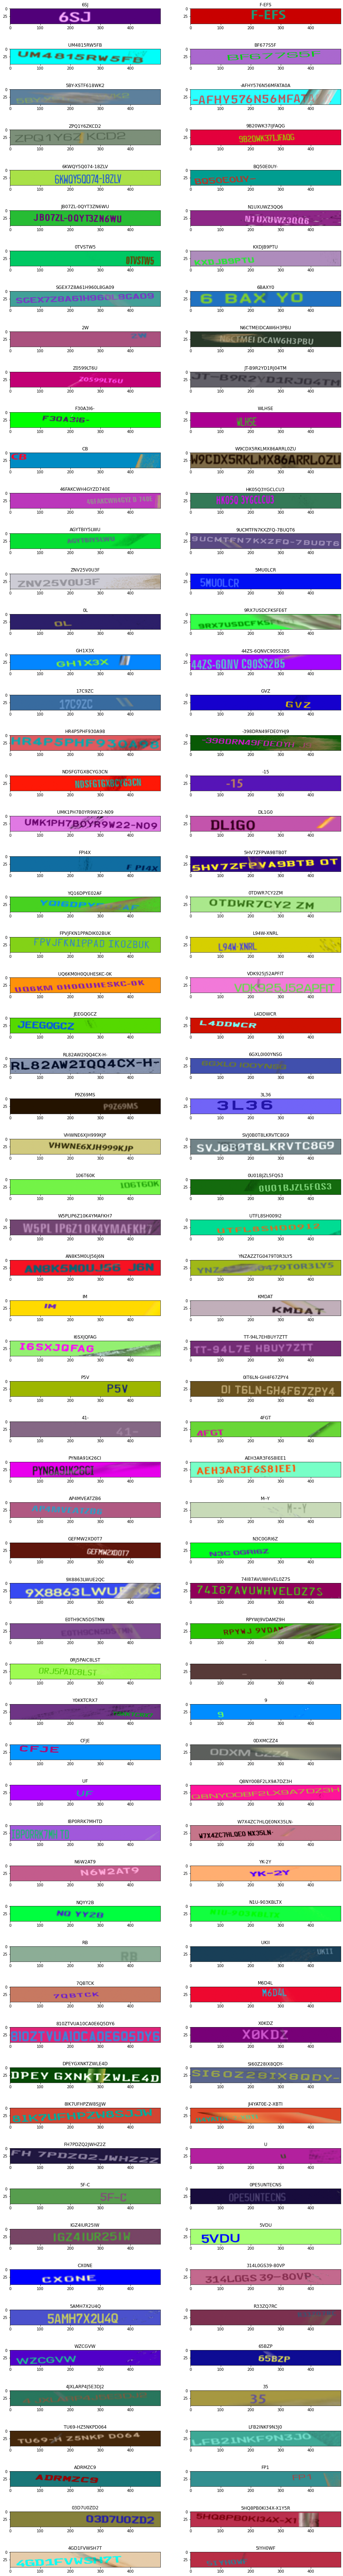

In [34]:
show_dataset_sample(train)

#4. Model creation

## MISC: custom layers & blocks

###CTC layer
>Used at the end of the network to calculate CTC loss for training.

In [35]:
class CTCLayer(layers.Layer):
    
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        '''
        y_true: tf.tensor with shape (batch_size, max_len), dtype=int64
        y_pred: tf.tensor with shape (batch_size, max_timesteps, num_characters), dtype=float
        '''

        # Compute the training time loss
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        label_lengths = tf.TensorArray(tf.int64, size=tf.shape(y_true)[0])

        def loop_body(i, label_lengths):
            return i + 1, label_lengths.write(i, [tf.math.count_nonzero(y_true[i])])

        _, label_lengths = tf.while_loop(lambda i, label_lengths: i < batch_len, loop_body, [0, label_lengths])
        label_lengths = label_lengths.stack()

        pred_lengths = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        pred_lengths = pred_lengths * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, pred_lengths, label_lengths)
        # Add it to the parent layer
        self.add_loss(loss) 

        # At inference, just return the model predictions
        return y_pred

####CTC layer test call

In [36]:
# shape: batch_size x max_len
true = tf.constant(([[1,8,6,3], [1,9,0,0]]), dtype="int64")
# shape: batch_size x max_timesteps x num_characters
pred = tf.zeros(shape=(2, 25, 10), dtype="float")

#ctc = CTCLayer()
#ctc.call(true, pred)

####Compare Python loop with tf.while_loop

> The custom CTC layer uses a `tf.while_loop`. As inference speed is critical there, benchmark testing has been implemented. In general, the Python loop is 1.3x faster than the tensorflow loop, which is the only possibility to iterate through dynamic tensors. This is essential to calculate input label lengths on the fly, and pass to `keras.backend.ctc_batch_cost`.

In [37]:
def tf_loop():
    true = tf.constant(([[1,8,6,3], [1,9,0,0]]), dtype="int64")
    batch_len = tf.cast(tf.shape(true)[0], dtype="int32")
    label_lengths = tf.TensorArray(tf.int64, size=tf.shape(true)[0])

    def loop_body(i, label_lengths):
        label_lengths.write(i, [tf.math.count_nonzero(true[i])]).mark_used()
        return i + 1, label_lengths

    _, label_lengths = tf.while_loop(
        lambda i, label_lengths: i < batch_len, loop_body, [0, label_lengths])

    label_lengths = label_lengths.stack()
    #print(label_lengths)
    return label_lengths

def python_loop():
    true = tf.constant(([[1,8,6,3], [1,9,0,0]]), dtype="int64")
    batch_len = tf.cast(tf.shape(true)[0], dtype="int32")
    label_lengths = tf.TensorArray(tf.int64, size=tf.shape(true)[0])

    for i in range(batch_len):
        label_length = [tf.math.count_nonzero(true[i])]
        label_lengths.write(i, label_length).mark_used()

    label_lengths = label_lengths.stack()
    #print(label_lengths)
    return label_lengths

In [38]:
import timeit
num_iters = 10000

tf_avg = (timeit.timeit(tf_loop, number=num_iters)/num_iters)*1000
python_avg = (timeit.timeit(python_loop, number=num_iters)/num_iters)*1000

print(f"TF loop: {tf_avg} ms")
print(f"Python loop: {python_avg} ms")

TF loop: 1.627517316300009 ms
Python loop: 1.2674883254999942 ms


###Custom convolutional layer
>To avoid boilerplate layer chaining, a custom convolutional layer is defined. It contains the following layers: convolution, batch normalization, dropout.

In [39]:
class Conv(layers.Layer):

    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, activation="relu", batchnorm_needed=True, dropout=0.1, name=""):
        super(Conv, self).__init__(name=name)

        # init layers
        self.conv = None
        self.dropout = layers.Dropout(rate=dropout, name=f"{name}_Dropout")
        self.bn = None

        # batch normalization
        self.use_bias = True
        if (batchnorm_needed):
            # bias is False, because batch norm already adds a constant
            self.use_bias = False
            self.bn = layers.BatchNormalization(name=f"{name}_BatchNorm")
        else:
            # bias is needed
            self.use_bias = True

        self.conv = layers.Conv2D(filters=out_channel, kernel_size=kernel_size, padding="same", strides=stride, dilation_rate=1, 
                                activation=activation, use_bias=self.use_bias, name=f"{name}_Convolution")

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.dropout(x)
        if (self.bn != None):
            x = self.bn(x)
        return x

In [40]:
conv = Conv(3, 8, 3, 1, "relu", True, 0.2, "Conv1")

In [41]:
y = conv(tf.ones([1, 32, 32, 3]))
print(y)

tf.Tensor(
[[[[0.5981939  0.14907345 0.02395383 ... 0.27237916 0.5136631
    0.55079365]
   [1.1419997  0.15741846 0.         ... 0.04032683 0.54282486
    0.6211755 ]
   [1.1419997  0.15741846 0.         ... 0.04032683 0.54282486
    0.6211755 ]
   ...
   [1.1419997  0.15741846 0.         ... 0.04032683 0.54282486
    0.6211755 ]
   [1.1419997  0.15741846 0.         ... 0.04032683 0.54282486
    0.6211755 ]
   [0.7040816  0.0745219  0.01417497 ... 0.         0.17978054
    0.5462662 ]]

  [[0.45280904 0.15300974 0.4384104  ... 0.07939478 0.7475993
    0.88142246]
   [1.1876417  0.4216622  0.08460205 ... 0.         0.8535713
    0.47621205]
   [1.1876417  0.4216622  0.08460205 ... 0.         0.8535713
    0.47621205]
   ...
   [1.1876417  0.4216622  0.08460205 ... 0.         0.8535713
    0.47621205]
   [1.1876417  0.4216622  0.08460205 ... 0.         0.8535713
    0.47621205]
   [0.6222053  0.6480015  0.         ... 0.         0.37409443
    0.        ]]

  [[0.45280904 0.15300974 0.4

### Custom Blur Pool layer
>To make the network shift-invariant (https://arxiv.org/pdf/1904.11486.pdf).

In [42]:
class BlurPool(layers.Layer):

    def __init__(self, kernel_size=3, stride=1, padding="same", name="", **kwargs):
        super(BlurPool, self).__init__(name=name, **kwargs)
        self.kernel = None
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.p_name = name
    
    def build(self, input_shape):
        # default kernel
        f = np.array([[1]])
        # choose kernel
        if (self.kernel_size == 1):
            f = np.array([[1.0,]])
        elif (self.kernel_size == 2):
            f = np.array([[1.0, 1.0]])
        elif (self.kernel_size == 3):
            f = np.array([[1.0, 2.0, 1.0]])
        elif (self.kernel_size == 4):    
            f = np.array([[1.0, 3.0, 3.0, 1.0]])
        elif (self.kernel_size == 5):    
            f = np.array([[1.0, 4.0, 6.0, 4.0, 1.0]])
        elif (self.kernel_size == 6):    
            f = np.array([[1.0, 5.0, 10.0, 10.0, 5.0, 1.0]])
        elif (self.kernel_size == 7):    
            f = np.array([[1.0, 6.0, 15.0, 20.0, 15.0, 6.0, 1.0]])
        # form 2D kernel
        f_transposed = f.T
        blur_kernel = f * f_transposed
        blur_kernel = blur_kernel / np.sum(blur_kernel)
        # blur kernels in the number of channels
        blur_kernel = np.repeat(blur_kernel, input_shape[3])
        blur_kernel = np.reshape(blur_kernel, (self.kernel_size, self.kernel_size, input_shape[3], 1))
        blur_init = keras.initializers.constant(blur_kernel)
        # initialize blur kernel
        self.kernel = self.add_weight(name='blur_kernel',
                                      shape=(self.kernel_size, self.kernel_size, input_shape[3], 1),
                                      initializer=blur_init, trainable=False)
        super(BlurPool, self).build(input_shape)

    def call(self, inputs):
        x = keras.backend.depthwise_conv2d(inputs, self.kernel, padding=self.padding, strides=(self.stride, self.stride))
        return x

    def compute_output_shape(self, input_shape):
        if (self.padding == "same"):
            # same padding
            return input_shape[0], int(np.ceil(input_shape[1] / self.stride)), int(np.ceil(input_shape[2] / self.stride)), input_shape[3]
        else:
            # valid padding
            return input_shape[0], int(input_shape[1] / self.stride), int(input_shape[2] / self.stride), input_shape[3]

    def get_config(self):
        base_config = super(BlurPool, self).get_config()
        config = {
            "kernel_size": self.kernel_size,
            "stride": self.stride,
            "padding": self.padding,
            "name": self.p_name
        }
        return dict(list(base_config.items()) + list(config.items()))

In [43]:
blurPool = BlurPool(kernel_size=3, stride=2, padding="same", name="1")

In [44]:
y = blurPool(tf.ones([1, 10, 10, 3]))
print(y)

tf.Tensor(
[[[[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [1.     1.     1.    ]
   [0.75   0.75   0.75  ]]

  [[0.75   0.75   0.75  ]
   [0.75   0.75   0.75  ]
   [0.75   0.75   0.75  ]
   [0.75   0.75   0.75  ]
   [0.5625 0.5625 0.5625]]]], shape=(1, 5, 5, 3), dtype=float32)


###Custom residual block
>To avoid the vanishing gradient problem, a block of convolutional layers is defined with skip connecton between its input and its output. That means, the input directly influences the output, not just the conv activations. Number of conv layers in a block can be defined with a parameter. The number of channels are identical in a block, only the last layer of the block does spatial scaling down & channel scaling up (by a factor of 2).

In [45]:
class Residual_block(tf.keras.Model):

    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, activation="relu", batchnorm_needed=True, dropout=0.2, 
                 num_layers=1, residual_needed=True, name=""):
        super(Residual_block, self).__init__(name=name)
        self.residual_needed = residual_needed
        self.residual_block = keras.Sequential(name=f"{name}_Conv{num_layers}x")
        # num_layers convolutional layers in a residual block
        for i in range(num_layers):
            self.residual_block.add(Conv(in_channel, in_channel, kernel_size, stride, activation, batchnorm_needed, dropout, f"{name}_Conv{i+1}"))
        # channel scaling convolution
        self.channel_scale = Conv(in_channel, out_channel, kernel_size, stride, activation, batchnorm_needed, dropout, f"{name}_ChannelScale")
        # spatial scaling shift invariant pooling layer
        self.spatial_scale = BlurPool(kernel_size=kernel_size, stride=2, padding="same", name=f"{name}_SpatialScale")

    def __call__(self, inputs, training=None):
        result = self.residual_block(inputs)
        # residual connection 
        if (self.residual_needed):
            result += inputs
        result = self.channel_scale(result)
        return self.spatial_scale(result)

In [46]:
residual_block = Residual_block(8, 16, 3, 1, "relu", True, 0.2, 1, True, "ResBlock1")

In [47]:
y = residual_block(tf.ones([1, 32, 32, 8]))
print(y)

tf.Tensor(
[[[[0.38378578 0.8631383  0.02644441 ... 0.         0.
    0.75936913]
   [0.51281035 0.6598087  0.05481157 ... 0.         0.
    1.1195618 ]
   [0.51281035 0.6598087  0.05481157 ... 0.         0.
    1.1195618 ]
   ...
   [0.51281035 0.6598087  0.05481157 ... 0.         0.
    1.1195618 ]
   [0.4985006  0.59286773 0.06996873 ... 0.         0.
    1.178525  ]
   [0.40307269 0.09801123 0.29735112 ... 0.         0.
    0.9257384 ]]

  [[0.5560837  1.0874915  0.         ... 0.         0.
    0.6038952 ]
   [0.75724953 0.82563406 0.         ... 0.         0.
    0.9264358 ]
   [0.75724953 0.82563406 0.         ... 0.         0.
    0.9264358 ]
   ...
   [0.75724953 0.82563406 0.         ... 0.         0.
    0.9264358 ]
   [0.7377721  0.7446079  0.         ... 0.         0.
    0.99773765]
   [0.58290744 0.12538236 0.09918972 ... 0.         0.
    0.85168284]]

  [[0.5560837  1.0874915  0.         ... 0.         0.
    0.6038952 ]
   [0.75724953 0.82563406 0.         ... 0.     

##Model definitions
>

###A: Basic OCR

In [48]:
def basic_ocr_model(image_dim: (int, int), in_channel: int, num_characters: int, optimizer, name):
    # Factor by which the image is going to be downsampled by the convolutional blocks.
    # Two convolutional blocks are used; each block has a pooling layer which downsample the features by a factor of 2.
    # Thus, the total downsampling factor is (2x2)=4.
    downsample_factor = 4
    # Model inputs
    input_image = layers.Input(shape=(image_dim[0], image_dim[1], in_channel), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Make the first dimension correspond to the width of the image
    # RNN part "reads" the image from left to right (instead of top to bottom)
    x = layers.Permute((2, 1, 3), name="Permute")(input_image)

    # 1st conv block
    x = layers.Conv2D(32, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(x)
    # 1st max pooling
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)

    # 2nd conv block
    x = layers.Conv2D(64, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    # 2nd max pooling
    x = layers.MaxPooling2D((2, 2), name="MaxPool2")(x)

    # Two max pool have been used with pool size and strides 2.
    # This way, the downsampled feature maps are 4x smaller. 
    # The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the features to the RNN part.
    # image_dim[1], image_dim[0] has reversed order because layers.Permute changed dim 1 & dim 2
    new_shape = ((image_dim[1] // downsample_factor), (image_dim[0] // downsample_factor) * 64)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    x = layers.Dense(64, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2, name="Dropout")(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name="LSTM1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25), name="LSTM2")(x)

    # Output layer
    # +1 for empty character
    x = layers.Dense(num_characters+1, activation="softmax", name="Dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTCloss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_image, labels], outputs=output, name=name)
    # Optimizer
    optimizer = optimizer
    # Compile the model
    model.compile(optimizer=optimizer)
    # Return the model to use
    return model

###B: Residual OCR

In [49]:
def residual_ocr_model(image_dim: (int, int), in_channel, num_characters, optimizer, 
                       num_features, num_blocks, layers_per_level, residual_needed,
                       kernel_size, stride, activation, batchnorm_needed, dropout, name):

    # Model inputs
    input_image = layers.Input(shape=(image_dim[0], image_dim[1], in_channel), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Make the first dimension correspond to the width of the image
    # RNN part "reads" the image from left to right (instead of top to bottom)
    x = layers.Permute((2, 1, 3), name="Permute")(input_image)

    # required image channels
    in_channels = in_channel
    out_channels = num_features
    x = Conv(in_channels, out_channels, kernel_size, stride, activation, batchnorm_needed, dropout, f"ChannelUp_Conv")(x)

    # num_blocks blocks needed
    for i in range(num_blocks):
        in_channels = out_channels
        out_channels *= 2
        x = Residual_block(in_channels, out_channels, kernel_size, stride, activation, batchnorm_needed, dropout, 
                           layers_per_level, residual_needed, f"ResBlock{i+1}")(x)

    # Factor by which the image is downsampled by the residual convolutional blocks.
    # Each block downsamples the features spatially by a factor of 2.
    downsample_factor = pow(2, num_blocks)

    # The downsampled feature maps are downsample_factor times smaller. 
    # The number of filters in the last layer is num_features*downsample_factor. 
    # Reshape accordingly before passing the features to the RNN part.
    # image_dim[1], image_dim[0] has reversed order because layers.Permute changed dim 1 & dim 2
    x_remain = image_dim[1] % downsample_factor > 0
    y_remain = image_dim[0] % downsample_factor > 0
    lstm_input_shape = ((image_dim[1] // downsample_factor) + x_remain, ((image_dim[0] // downsample_factor) + y_remain) * out_channels)
    x = layers.Reshape(target_shape=lstm_input_shape, name="Reshape")(x)
    x = layers.Dense(64, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2, name="Dropout")(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name="LSTM1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25), name="LSTM2")(x)

    # Output layer
    # +1 for the empty character
    x = layers.Dense(num_characters+1, activation="softmax", name="Dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTCloss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_image, labels], outputs=output, name=name)
    # Optimizer
    optimizer = optimizer
    # Compile the model
    model.compile(optimizer=optimizer)
    # Return the model to use
    return model

##Build model

In [50]:
model_characters = train.char_to_num.get_vocabulary()
model_characters = sorted(model_characters)
print(model_characters)
print(len(model_characters))

['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[?]']
37


In [51]:
learning_rate = 1e-3
num_features=32
num_blocks=2
layers_per_level=1
residual_needed=True
kernel_size=3
stride=1
activation="relu"
batchnorm_needed=True
dropout=0.1
model_name="Residual_OCR"

training_config = {
    "img": (img_h, img_w),
    "n_channels": n_channels,
    "batch_size": batch_size,
    "train_epoch_size": train_epoch_size,
    "val_epoch_size": val_epoch_size,
    "replace_chars": replace_chars,
    "min_len": min_len,
    "max_len": max_len,
    "font_size": font_size,
    "model_characters": model_characters,
    "num_model_characters": len(model_characters),
    "learning_rate": learning_rate,
    "num_features": num_features,
    "num_blocks": num_blocks,
    "layers_per_level": layers_per_level,
    "residual_needed": residual_needed,
    "kernel_size": kernel_size,
    "stride": stride,
    "activation": activation,
    "batchnorm_needed": batchnorm_needed,
    "dropout": dropout,
    "name": model_name,
}

with open(f"{training_dir}config.json", 'w', encoding='utf-8') as f:
    json.dump(training_config, f, ensure_ascii=False, indent=4)

with open(f'{training_dir}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

In [52]:
# Create the model
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model = None
gc.collect()

'''
model = basic_ocr_model(image_dim=(img_h, img_w), in_channel=n_channels, num_characters=len(model_characters), optimizer=optimizer, 
                        name=model_name)
'''
model = residual_ocr_model(image_dim=(img_h, img_w), in_channel=n_channels, num_characters=len(model_characters), optimizer=optimizer,
                           num_features=num_features, num_blocks=num_blocks, layers_per_level=layers_per_level, residual_needed=residual_needed,
                           kernel_size=kernel_size, stride=stride, activation=activation, batchnorm_needed=batchnorm_needed, dropout=dropout, name=model_name)

model.summary()

Model: "Residual_OCR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 50, 500, 3)] 0                                            
__________________________________________________________________________________________________
Permute (Permute)               (None, 500, 50, 3)   0           image[0][0]                      
__________________________________________________________________________________________________
ChannelUp_Conv (Conv)           (None, 500, 50, 32)  992         Permute[0][0]                    
__________________________________________________________________________________________________
ResBlock1_Conv1x (Sequential)   (None, 500, 50, 32)  9344        ChannelUp_Conv[0][0]             
_______________________________________________________________________________________

#5. Training configuration

##General parameters, general callbacks

In [53]:
epochs = 100 #1000

# Early stopping configuration
early_stopping_patience = 10 #50
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, verbose=1, restore_best_weights=True
)

# Save model checkpoint configuration
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss", mode='auto', filepath=checkpoint_dir, save_weights_only=True, save_best_only=True
)

# TensorBoard configuration
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    embeddings_freq=0,
    write_graph=False,
    update_freq='epoch')

##Specific callbacks

In [54]:
# Learning rate scheduler
n_epochs_before_lr_decrease = 100
# Keep the initial learning rate for the first n_epochs_before_lr_decrease and decrease exponentially after that
def lr_schedule(epoch, lr):
    if epoch < n_epochs_before_lr_decrease:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Reduce learning rate on plateau configuration
on_plateau_patience = 10
on_plateau_min_delta = 0.0001
on_plateau_min_lr = 1e-5
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=on_plateau_patience, verbose=1, mode='auto', 
    min_delta=on_plateau_min_delta, cooldown=0, min_lr=on_plateau_min_lr
)

##TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
print(log_dir)
print(hyperopt_logs_dir)

/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/training/realm_20210417-072639/logs/
/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/hyperopt/realm_20210417-072639/logs/


In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/training/realm_20210417-072639/logs/"

#6. Training

##A: Single training

In [ ]:
#Train the model
training_history = model.fit(
    train.dataset,
    validation_data=validation.dataset,
    # to plot training countinously in TensorBoard, set it to the value trained SO FAR when loading & training a model further
    initial_epoch=0,
    epochs=epochs,
    callbacks=[early_stopping, save_checkpoint, tensorboard_callback]
)

1563/1563 [==============================] - 735s 455ms/step - loss: 44.2448 - val_loss: 31.5176


In [ ]:
best_loss = min(training_history.history["val_loss"])
n_epoch_trained = 0
print(best_loss)

31.51763343811035


##B: Hyperopt project

### Specify constants & variables with ranges

In [ ]:
hp = HyperParameters()

# constants
hp.Fixed(name='img_dim_0', value=50)
hp.Fixed(name='img_dim_1', value=500)
hp.Fixed(name='in_channel', value=1)
hp.Fixed(name='num_characters', value=37)
hp.Fixed(name='stride', value=1)
hp.Fixed(name='learning_rate', value=1e-3)
# variables
hp.Choice(name='num_features', values=[8, 16, 32, 64])
hp.Choice(name='kernel_size', values=[3, 5])
hp.Choice(name='activation', values=["relu", "elu", "tanh"])
hp.Boolean(name='residual_needed', default=True)
hp.Boolean(name='batchnorm_needed', default=True)
hp.Float(name='dropout', min_value=0, max_value=0.6, step=None, sampling='linear', default=0.1)
hp.Int(name='num_blocks', min_value=1, max_value=3, step=1, default=2)
hp.Int(name='layers_per_level', min_value=1, max_value=4, step=1, default=1)

print(f"Default parameters: {hp.values}")

Default parameters: {'img_dim_0': 50, 'img_dim_1': 500, 'in_channel': 1, 'num_characters': 37, 'stride': 1, 'learning_rate': 0.001, 'num_features': 8, 'kernel_size': 3, 'activation': 'relu', 'residual_needed': True, 'batchnorm_needed': True, 'dropout': 0.1, 'num_blocks': 2, 'layers_per_level': 1}


### Hyperopt project

In [ ]:
print(f"Hyperopt project: {hyperopt_dir}")

Hyperopt project: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20210418-143210/hyperopt/


### Define model builder method

In [ ]:
def model_builder(hp):
    gc.collect()

    img_dim_0 = hp['img_dim_0']
    img_dim_1 = hp['img_dim_1']
    in_channel = hp['in_channel']
    num_characters = hp['num_characters']
    stride = hp['stride']
    learning_rate = hp['learning_rate']
    
    num_features = hp['num_features']
    num_blocks = hp['num_blocks']
    layers_per_level = hp['layers_per_level']
    residual_needed = hp['residual_needed']
    kernel_size = hp['kernel_size']
    activation = hp['activation']
    batchnorm_needed = hp['batchnorm_needed']
    dropout = hp['dropout']

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model = residual_ocr_model(image_dim=(img_dim_0, img_dim_1), in_channel=in_channel, num_characters=num_characters, optimizer=optimizer,
                           num_features=num_features, num_blocks=num_blocks, layers_per_level=layers_per_level, residual_needed=residual_needed,
                           kernel_size=kernel_size, stride=stride, activation=activation, batchnorm_needed=batchnorm_needed, dropout=dropout, name="Residual_OCR")
    return model

### Init tuner

In [ ]:
factor = 7
hyperband_iterations=1

epochs_per_iteration = epochs * (math.log(epochs, factor) ** 2)
all_epochs = math.ceil(epochs_per_iteration * hyperband_iterations)

tuner = kt.tuners.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=epochs,
    factor=factor,
    hyperband_iterations=hyperband_iterations,
    seed=42,
    hyperparameters=hp,
    directory=hyperopt_dir,
    project_name=f"hyperopt"
)
tuner.search_space_summary()
print(f"\nAll epochs: {all_epochs}")
print(f"Hyperopt project root: {hyperopt_dir}")

with open(f'{hyperopt_dir}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20210418-143210/hyperopt/hyperopt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/projects/realm_20210418-143210/hyperopt/hyperopt/tuner0.json
Search space summary
Default search space size: 14
img_dim_0 (Fixed)
{'conditions': [], 'value': 50}
img_dim_1 (Fixed)
{'conditions': [], 'value': 500}
in_channel (Fixed)
{'conditions': [], 'value': 1}
num_characters (Fixed)
{'conditions': [], 'value': 37}
stride (Fixed)
{'conditions': [], 'value': 1}
learning_rate (Fixed)
{'conditions': [], 'value': 0.001}
num_features (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'tanh'], 'ordere

In [ ]:
tensorboard_tuner_callback = tf.keras.callbacks.TensorBoard(
    log_dir=hyperopt_logs_dir,
    histogram_freq=1,
    embeddings_freq=0,
    write_graph=False,
    update_freq='epoch')

###Run hyperparameter optimization

In [ ]:
tuner.search(
    x=train.dataset,
    validation_data=validation.dataset,
    # to plot training countinously in TensorBoard, set it to the value trained SO FAR when loading & training a model further
    initial_epoch=2,
    epochs=epochs,
    callbacks=[tensorboard_tuner_callback, early_stopping],
    use_multiprocessing=True
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
img_dim_0         |50                |50                
img_dim_1         |500               |500               
in_channel        |1                 |1                 
num_characters    |37                |37                
stride            |1                 |1                 
learning_rate     |0.001             |0.001             
num_features      |16                |64                
kernel_size       |5                 |3                 
activation        |relu              |elu               
residual_needed   |False             |False             
batchnorm_needed  |True              |True              
dropout           |0.10676           |0.30359           
num_blocks        |2                 |2                 
layers_per_level  |2                 |3                 
tuner/epochs      |3                 |3                 
tuner/initial_e...|0                 |0                 
tune

### Retrieve best configuration so far

In [ ]:
# Get the optimal hyperparameters
optimal_hyparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(optimal_hyparams.values)

tuner.results_summary(3)

{'x': 3, 'y': 4, 'z': 2, 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Results summary
Results in /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/hyperopt/opt_20210413-181502
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
x: 3
y: 4
z: 2
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 39.42935562133789
Trial summary
Hyperparameters:
x: 2
y: 2
z: 3
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 39.764686584472656
Trial summary
Hyperparameters:
x: 4
y: 1
z: 4
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: f93c5f2c0362d31ab097b470c5170e8d
Score: 40.609230041503906


### Retrieve best model(s) so far

In [ ]:
best_models = tuner.get_best_models(num_models=1)
best_models[0].summary()

Model: "Residual_OCR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 50, 500, 1)] 0                                            
__________________________________________________________________________________________________
Permute (Permute)               (None, 500, 50, 1)   0           image[0][0]                      
__________________________________________________________________________________________________
ResBlock1_Conv1x (Sequential)   (None, 500, 50, 32)  416         Permute[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 500, 50, 32)  0           ResBlock1_Conv1x[0][0]           
                                                                 Permute[0][0]         

#7. Evaluation

In [ ]:
loss = model.evaluate(validation.dataset, verbose=2)
print("loss: {:2.4f}".format(loss))

313/313 - 104s - loss: 31.4827
loss: 31.4827


#8. Model I/O

##Save model

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"{model.name}_{current_time}_plate_epoch{n_epoch_trained}_loss{'{0:.4f}'.format(best_loss)}"
model.save(f"{keras_dir}{model_name}")

with open(f"{keras_dir}{model_name}{sep}config.json", 'w', encoding='utf-8') as f:
    json.dump(training_config, f, ensure_ascii=False, indent=4)
with open(f'{keras_dir}{model_name}{sep}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

print(f"Model saved: {model_name}")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/keras/Residual_OCR_20210502-120201_plate_epoch0_loss31.5176/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/keras/Residual_OCR_20210502-120201_plate_epoch0_loss31.5176/assets


Model saved: Residual_OCR_20210502-120201_plate_epoch0_loss31.5176


##Load model

In [ ]:
model_name = f"Residual_OCR_20210502-102820_plate_epoch1_loss31.5176"
model = keras.models.load_model(f"{keras_dir}{model_name}")

with open(f"{keras_dir}{model_name}{sep}config.json") as f:
  training_config = json.load(f)

# Re-evaluate the model
loss = model.evaluate(validation.dataset, verbose=2)
print("Loaded model, loss: {:2.4f}".format(loss))

313/313 - 105s - loss: 31.9365
Loaded model, loss: 31.9365


##Load weights

In [ ]:
# Loads the weights
model.load_weights(checkpoint_dir)

# Re-evaluate the model
loss = model.evaluate(validation.dataset, verbose=2)
print("Loaded model, loss: {:2.4f}".format(loss))

79/79 - 79s - loss: 0.0827
Loaded model, loss: 0.0827


#9. Inference model

>Create the pure prediction model & run inference on it.

##Build prediction model

In [ ]:
prediction_model = None
gc.collect()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="Dense2").output)
prediction_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 50, 500, 3)] 0                                            
__________________________________________________________________________________________________
Permute (Permute)               (None, 500, 50, 3)   0           image[0][0]                      
__________________________________________________________________________________________________
InputUpscale_Conv (Conv)        (None, 500, 50, 32)  992         Permute[0][0]                    
__________________________________________________________________________________________________
ResBlock1_Conv1x (Sequential)   (None, 500, 50, 32)  9344        InputUpscale_Conv[0][0]          
______________________________________________________________________________________________

##Run inference

In [ ]:
# A utility function to decode the output of the network
def batch_ctc_decode(preds, max_length):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_length]
    return results

def show_inference_results(dataset_wrapper, model):

    batch_size = dataset_wrapper.batch_size
    img_in_line = 2
    num_lines = dataset_wrapper.batch_size // img_in_line
    img_size_w = 8
    img_size_h = 2

    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))
    
    for batch in dataset_wrapper.dataset.take(1):
        images = batch['image']
        labels = batch['label']
        preds = model.predict(images)
        preds = batch_ctc_decode(preds, dataset_wrapper.max_len)

        for i in range(batch_size):
            img = dataset_wrapper.decode_image(images[i])
            # if image has only one channel, drop channel dim to plot with matplotlib
            if(img.shape[2] == 1):
                img = img[:,:,0]

            label = "\n" + dataset_wrapper.decode_label(labels[i], True) + " [True]\n" + dataset_wrapper.decode_label(preds[i], True) + " [Pred]"
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)
    plt.show()

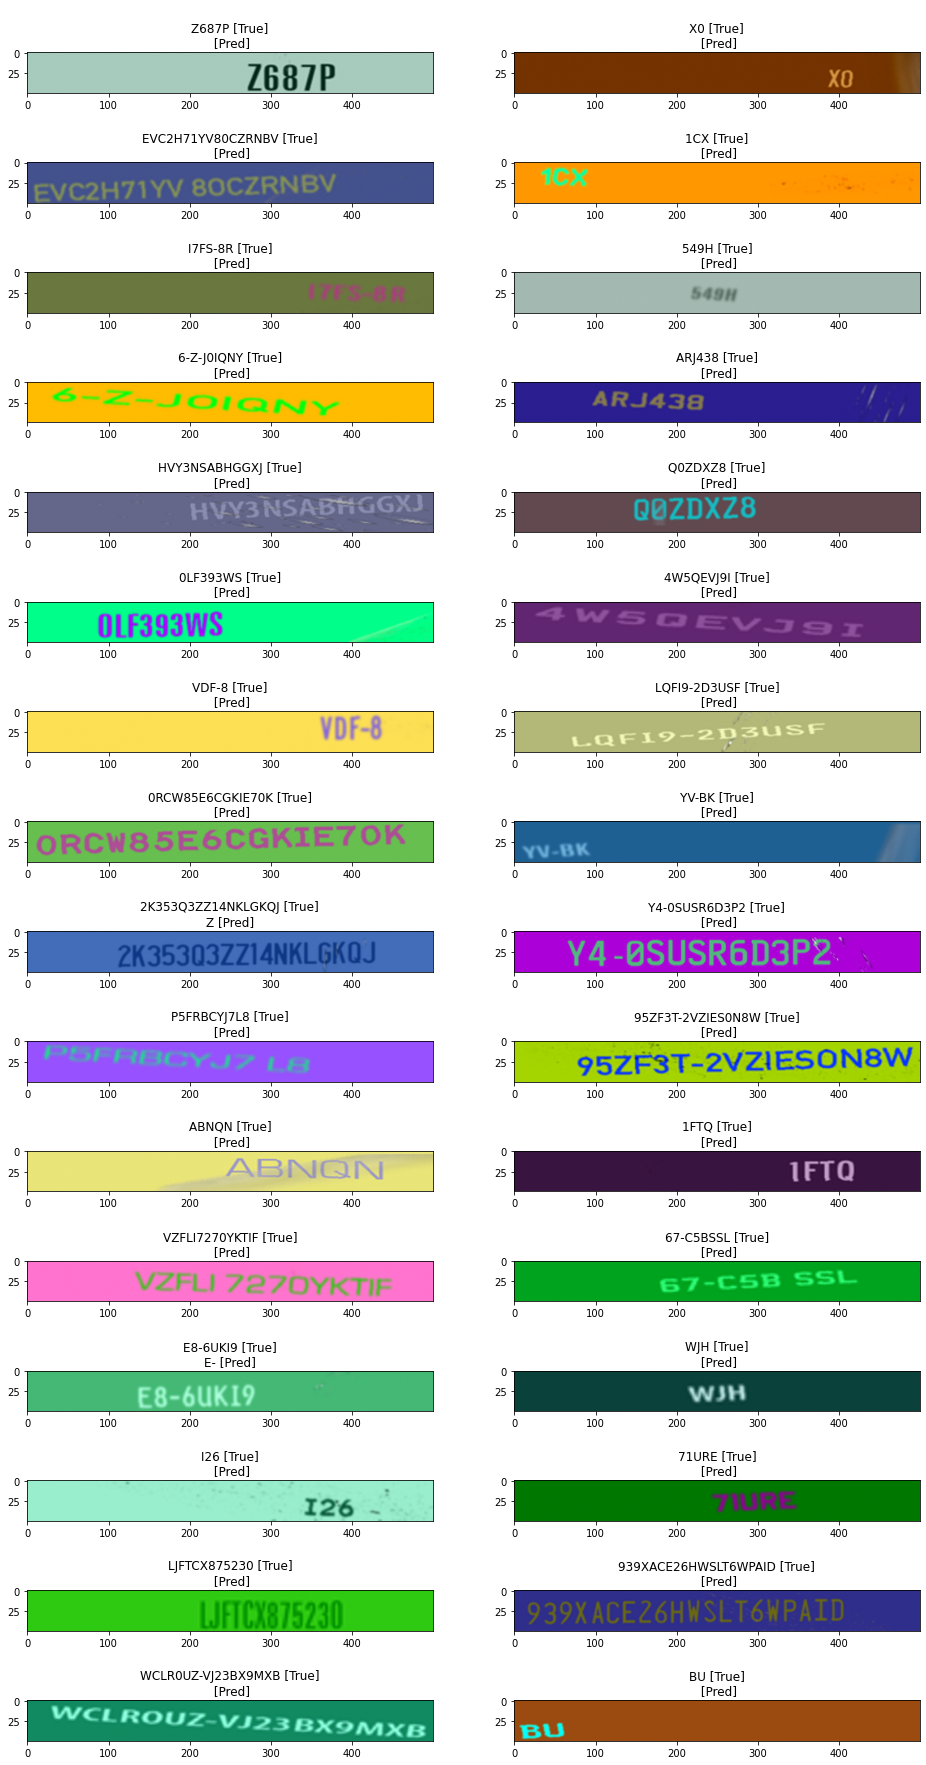

In [ ]:
show_inference_results(validation, prediction_model)

#10. TFLite conversion

##Define source model, create individual tmp model

In [ ]:
model_name = f"Residual_OCR_20210502-102820_plate_epoch1_loss31.5176"

# Save the pure prediction model to model_tmp_dir before the tflite conversion
source_model = keras.models.load_model(f"{keras_dir}{model_name}")

with open(f"{keras_dir}{model_name}{sep}config.json") as f:
  config = json.load(f)

target_model = keras.models.Model(source_model.get_layer(name="image").input, source_model.get_layer(name="Dense2").output)
print(target_model.get_layer(name="image").input)
print(target_model.get_layer(name="Dense2").output)

# set constant shapes to have Android tflite GPU interpreter support
target_model.input.set_shape((1, 50, 500, 3))
target_model.output.set_shape((1, 125, 38))
print(target_model.get_layer(name="image").input)
print(target_model.get_layer(name="Dense2").output)

target_model.save(model_tmp_dir)
source_model = None
target_model = None
gc.collect()

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 500, 3), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 125, 38), dtype=tf.float32, name=None), name='Dense2/truediv:0', description="created by layer 'Dense2'")
KerasTensor(type_spec=TensorSpec(shape=(1, 50, 500, 3), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
KerasTensor(type_spec=TensorSpec(shape=(1, 125, 38), dtype=tf.float32, name=None), name='Dense2/truediv:0', description="created by layer 'Dense2'")


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tmp/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tmp/assets


761086

##Convert to tflite

>Note: Recurrent/LSTM layers have quantization issues due to a Tensorflow bug so full-integer quantization cannot be done at the moment (reason of uncommented lines). Dynamic range quantization is used, which reduces the size of the model to 1/4.

In [ ]:
def representative_dataset():
    
     for item in train.dataset.take(100):
         # to return shape=(batch_size x img) array
         #image = item["image"]

         # to return shape=(1 x img) array
         image = tf.expand_dims(item["image"][0], axis=0)

         yield image

(1, 50, 500, 3)


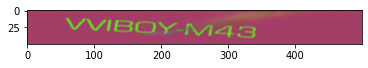

In [ ]:
img = next(representative_dataset())

print(img.shape)
img = train.decode_image(img[0])

# if image has only one channel, drop channel dim to plot with matplotlib
if(img.shape[2] == 1):
    img = img[:,:,0]
imgplot = plt.imshow(img)
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_tmp_dir)
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True

#Dynamic integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#Full integer quantization
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
#converter.representative_dataset = representative_dataset

tflite_model = converter.convert()
target_file_dir = f"{tflite_dir}{model_name}{sep}"
target_file_path = f"{target_file_dir}model.tflite"

if not os.path.exists(target_file_dir):
    os.makedirs(target_file_dir)

# Save the tflite model
with open(target_file_path, 'wb') as f:
  f.write(tflite_model)
  print(f"Model saved successfully to {target_file_path}")

with open(f"{target_file_dir}config.json", 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)
with open(f'{target_file_dir}characters.txt', 'w') as f:
    for item in model_characters:
        f.write(f"{item}\n")

Model saved successfully to /content/drive/My Drive/Machine Learning/Stolen Vehicle Detector/OCR/model/tflite/Residual_OCR_20210502-102820_plate_epoch1_loss31.5176/model.tflite


##TFLite model details

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
#interpreter = tf.lite.Interpreter(model_path=f"{tflite_dir}model.tflite")

# Get input and output tensors
input = interpreter.get_input_details()
input_type = interpreter.get_input_details()[0]['dtype']
input_shape = input[0]['shape']
input_idx = input[0]['index']

output = interpreter.get_output_details()
output_type = interpreter.get_output_details()[0]['dtype']
output_shape = output[0]['shape']
output_idx = output[0]['index']

print('input: ', input)
print('type: ', input_type)
print('shape: ', input_shape)
print('index: ', input_idx)
print()
print('output: ', output)
print('type: ', output_type)
print('shape: ', output_shape)
print('index: ', output_idx)

input:  [{'name': 'serving_default_image:0', 'index': 0, 'shape': array([  1,  50, 500,   3], dtype=int32), 'shape_signature': array([ -1,  50, 500,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
type:  <class 'numpy.float32'>
shape:  [  1  50 500   3]
index:  0

output:  [{'name': 'StatefulPartitionedCall:0', 'index': 159, 'shape': array([ 1,  1, 38], dtype=int32), 'shape_signature': array([-1, -1, 38], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
type:  <class 'numpy.float32'>
shape:  [ 1  1 38]
index:  159


##TFLite model inference

(1, 50, 500, 3)


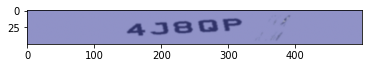

In [ ]:
# Generate random input image to test the model
random_input = next(representative_dataset())
#random_input = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print(random_input.shape)
random_input_plottable = train.decode_image(random_input[0])

# if image has only one channel, drop channel dim to plot with matplotlib
if(random_input_plottable.shape[2] == 1):
    random_input_plottable = random_input_plottable[:,:,0]
imgplot = plt.imshow(random_input_plottable)
plt.show()

In [ ]:
interpreter.allocate_tensors()

# Test the model on random input data
interpreter.set_tensor(input_idx, random_input)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data
# Use `tensor()` in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_idx)
print(output_data)
print(output_data.shape)

[[[8.7930488e-08 2.3034583e-04 1.2968229e-04 ... 1.7002472e-05
   5.9886268e-05 9.9603879e-01]
  [2.4920046e-09 3.5687983e-05 1.9563160e-05 ... 2.4606559e-06
   6.8686186e-06 9.9930823e-01]
  [9.2818642e-10 1.8509716e-05 1.2772440e-05 ... 1.5238758e-06
   3.2481519e-06 9.9955958e-01]
  ...
  [1.1333324e-09 1.6715787e-05 1.5684021e-05 ... 2.0007981e-06
   2.6676557e-06 9.9951088e-01]
  [4.4239106e-09 2.9807368e-05 3.2329808e-05 ... 6.4539413e-06
   5.9235936e-06 9.9904913e-01]
  [1.8194105e-07 2.4190125e-04 1.9541006e-04 ... 7.6506672e-05
   9.9335462e-05 9.9287450e-01]]]
(1, 125, 38)


In [ ]:
np_output_data = np.array(output_data)
output = []

for item in np_output_data[0,:,]:
    output.append(np.argmax(item))

print(output)

[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]
